In [1]:
# !pip install langgraph

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from typing import TypedDict, Literal

class PortfolioState(TypedDict):
    total_usd: float
    amount_usd: float
    target_currency: Literal["USD", "INR", "EUR"]
    total: float

def get_conversion(state: PortfolioState) -> str:
    return state["target_currency"]

def get_total_usd(state: PortfolioState) -> PortfolioState:
    state["total_usd"] = state["amount_usd"] * 1.5
    return state

def get_total_inr(state: PortfolioState) -> PortfolioState:
    state["total"] = state["total_usd"] * 95
    return state

def get_total_eur(state: PortfolioState) -> PortfolioState:
    state["total"] = state["total_usd"] * 0.85
    return state

In [4]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(state_schema=PortfolioState)

builder.add_edge(START,  "get_total_usd")
builder.add_node("get_total_usd", get_total_usd)

builder.add_conditional_edges("get_total_usd", 
    get_conversion,
    {
    "INR": "get_total_inr",
    "EUR": "get_total_eur"
})
builder.add_node("get_total_inr", get_total_inr)
builder.add_node("get_total_eur", get_total_eur)
builder.add_edge(["get_total_inr", "get_total_eur"], END)

checkpointer = MemorySaver() 
# graph = builder.compile(checkpointer=checkpointer)
graph = builder.compile()

# Invoking the graph
# graph.invoke({"amount_usd": 100, "target_currency": "INR"})
# graph.invoke({"amount_usd": 200, "target_currency": "EUR"})

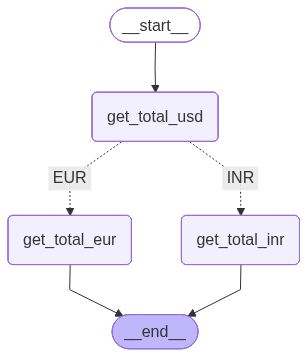

In [5]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [6]:
from langchain.chat_models import init_chat_model
from typing import Annotated, cast
from langgraph.graph.message import add_messages

llm = init_chat_model(model="gemini-2.5-flash", model_provider="google_genai") 

class State(TypedDict):
    messages: Annotated[list, add_messages] 

def chatbot(state: State) -> State:
    return { "messages" : [llm.invoke(state["messages"])]}

builder = StateGraph(state_schema=State)

builder.add_edge(START, "chatbot")
builder.add_node("chatbot", chatbot)
graph = builder.compile()



In [7]:
messages = { "role": "user", "content":  "Who is the top scorer in the world in test cricket?"}

response = graph.invoke({"messages": [messages]})

result = response["messages"]
print("Question: ", result[0].content)
print("Answer: ", result[-1].content)

Question:  Who is the top scorer in the world in test cricket?
Answer:  The top scorer in Test cricket, in terms of **total career runs**, is **Sachin Tendulkar** from India.

He scored **15,921 runs** in 200 Test matches during his career. He also holds the record for the most Test centuries, with 51.

If you were thinking of the highest **average**, that would be Don Bradman (99.94).
If you were thinking of the highest **individual score** in an innings, that belongs to Brian Lara (400* not out).


In [10]:
state = None

while True:
    input_message = input("Enter your message: ")
    if input_message.lower() in ["exit", "quit", "q"]:
        break

    if state is None:
        state = {"messages": [{"role": "user", "content": input_message}]}   
    else:
        state["messages"].append({"role": "user", "content": input_message})

    state = cast(State, graph.invoke(state))
    result = state["messages"]
    print("Question: ", result[0].content)
    print("Answer: ", result[-1].content)


Question:  who is the top scorer in test circket ?
Answer:  The top scorer in Test cricket is **Sachin Tendulkar** from India.

He holds the record for the most runs in the format with an incredible **15,921 runs** from 200 matches.

Here's a quick look at his career stats in Test cricket:

*   **Runs:** 15,921
*   **Matches:** 200
*   **Innings:** 329
*   **Average:** 53.78
*   **Centuries:** 51 (also a record)
*   **Half-centuries:** 68
*   **Career Span:** 1989-2013
Question:  who is the top scorer in test circket ?
Answer:  That's a fantastic question, and one that sparks a lot of debate among cricket fans! There isn't a single, universally agreed-upon "best" batsman in ODI cricket because different players excel in different ways and in different eras.

However, a few names consistently come up in the discussion, each with a strong claim:

1.  **Virat Kohli (India):**
    *   **Why he's often considered the best:** His sheer consistency is unparalleled in the modern era. He has an